In [1]:
import os 
os.chdir("../../../../")
import random
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scripts.python.PdfParse import *
from scripts.python.utils import *
from scripts.python.ts_utils import *

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
fiji_folder = os.getcwd() + "/data/tourism/fiji/intermediate/"
fiji_files = os.listdir(fiji_folder)
filepaths = [fiji_folder + file for file in fiji_files]

## Fiji Census

In [3]:
file_17_19 = "visitors_by_origin_month_17_19.csv"
file_20_22 = "visitors_by_month_20_22.csv"

df17_19 = pd.read_csv(fiji_folder + file_17_19).drop("Unnamed: 0", axis=1)
df20_22 = pd.read_csv(fiji_folder + file_20_22).drop("Unnamed: 0", axis=1)

df = pd.concat([df17_19, df20_22], axis=0)
df["dates"] = pd.to_datetime(df["dates"])
df["month"] = df["dates"].dt.month
df = (df.sort_values(by="dates")
      .reset_index()
      .drop("index", axis=1)
      .fillna(0))

cols = df.columns[~df.columns.isin(["dates", "year", "month"])]
for col in cols:
    df[col] = df[col].astype(int)

df.head(5)

,dates,year,australia,newzealand,usa,canada,japan,southkorea,restofasia,pacificislands,others,total,unitedkingdom,continentaleurope,year/month,month,visitors
0,2017-12-01,2017,36786,14573,7262,988,409,833,5972,5253,597,77430,1616,3141,0,12,0
1,2018-01-01,2018,28313,10612,5617,1000,505,792,5569,5529,438,62648,1321,2952,0,1,0
2,2018-02-01,2018,17014,6641,5951,993,510,553,8245,4416,541,48798,1252,2682,0,2,0
3,2018-03-01,2018,25196,9868,7264,1196,427,720,6667,4112,428,60058,1474,2706,0,3,0
4,2018-04-01,2018,26809,13731,6170,908,438,760,6346,3926,423,63535,1261,2763,0,4,0


In [4]:
get_adf_df(df.diff().dropna(), ["total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-6.269657,4.033390e-08,0.0,59.0,-3.546395,-2.911939,-2.593652


## Aviation Data

In [11]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)
aviation.head(5)

,Country,ISO,Region,Date,Aircraft_type,Seats_arrivals_domestic,Seats_arrivals_interregional,Seats_arrivals_intraregional,Seats_arrivals_intl,Seats_arrivals_total,Available_seat_kilometers,Number_of_flights_domestic,Number_of_flights_interregional,Number_of_flights_intraregional,Number_of_flights_intl,Number_of_flights_total
0,Fiji,FJ,East Asia & Pacific,2019-01-01,passenger,839,273,3480,3753,4592,1.430416e+07,8,1,10,11,19
1,Fiji,FJ,East Asia & Pacific,2019-01-02,passenger,974,313,3471,3784,4758,1.495610e+07,8,1,10,11,19
2,Fiji,FJ,East Asia & Pacific,2019-01-03,passenger,1190,443,3675,4118,5308,1.592143e+07,10,2,12,14,24
3,Fiji,FJ,East Asia & Pacific,2019-01-04,passenger,831,586,3159,3745,4576,1.457334e+07,7,2,12,14,21
4,Fiji,FJ,East Asia & Pacific,2019-01-05,passenger,744,273,4752,5025,5769,1.773449e+07,7,1,12,13,20


In [13]:
fj_avi = (aviation[(aviation.ISO == "FJ") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Number_of_flights_intl", "Number_of_flights_total",
            "Seats_arrivals_intl", "Seats_arrivals_total"]])

dates = pd.DataFrame(pd.date_range(start="2019-01-01",
                                   end="2022-09-30"), columns=["dates"])

fj_avi = dates.merge(fj_avi, how="left", left_on="dates", right_on="Date")
fj_avi["dates"] = pd.to_datetime(fj_avi["dates"])
fj_avi["month"], fj_avi["year"] = fj_avi["dates"].dt.month, fj_avi["dates"].dt.year

fj_avi_19_22 = fj_avi.groupby(by=["year", "month"]).sum().reset_index()
fj_merged = fj_avi_19_22.merge(df, left_on=["year", "month"], right_on=["year", "month"])

fj_merged = fj_merged.drop("year", axis=1)
fj_merged.columns = fj_merged.columns.str.lower()
fj_merged.to_csv(fiji_folder + "fj_merged.csv", encoding="utf-8")
fj_merged.head(5)

,month,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,dates,australia,newzealand,usa,canada,japan,southkorea,restofasia,pacificislands,others,total,unitedkingdom,continentaleurope,year/month,visitors
0,1,419.0,704.0,123265.0,150281.0,2019-01-01,27860,11573,5709,1121,1127,766,5806,5203,471,63807,1265,2906,0,0
1,2,330.0,596.0,86745.0,112482.0,2019-02-01,15489,7145,5855,1023,1203,677,8205,5011,410,48748,1375,2355,0,0
2,3,345.0,611.0,90965.0,114474.0,2019-03-01,22972,9457,8323,1247,1468,586,6302,4240,482,59306,1471,2758,0,0
3,4,321.0,442.0,105318.0,115571.0,2019-04-01,32850,16126,7938,1090,1125,648,7291,4646,432,76813,1444,3223,0,0
4,5,333.0,512.0,98428.0,118095.0,2019-05-01,30035,16372,8585,984,944,813,6876,4179,471,73169,1374,2536,0,0


## EDA
### Visualization

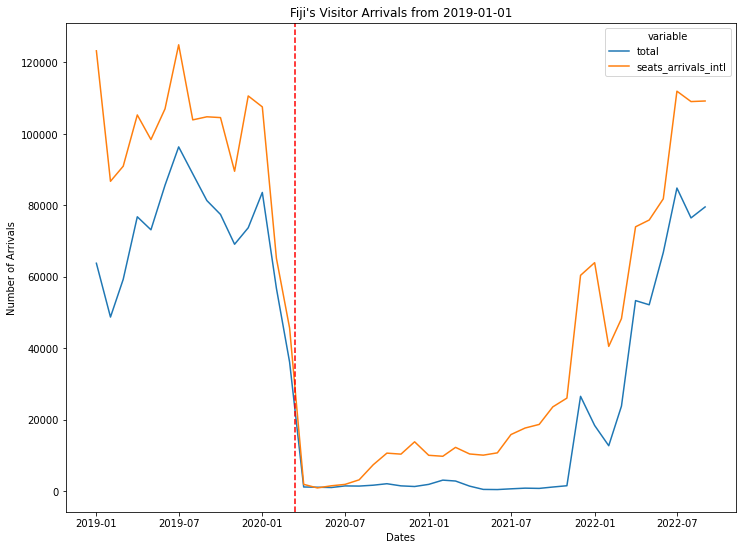

In [14]:
viz_df = fj_merged[["dates", "total", "seats_arrivals_intl"]]
viz_df = pd.melt(viz_df, "dates")
viz_df["value"] = viz_df["value"].astype(float)


plt.figure(figsize=(12, 9))
# sns.set_style("whitegrid")
sns.lineplot(data=viz_df, x="dates", y="value", hue="variable")
plt.xlabel("Dates")
plt.axvline(datetime.datetime(2020, 3, 12), linestyle="dashed", color="red")
plt.ylabel("Number of Arrivals")
plt.title("Fiji's Visitor Arrivals from 2019-01-01")
# plt.xticks(rotation=45)
plt.savefig("fiji.png", dpi=400)

### Correlation
#### Pearson Correlaton Coefficient

In [15]:
from scipy.stats import pearsonr


corr_seats_max, _ = pearsonr(fj_merged["seats_arrivals_total"], fj_merged["total"])
corr_seat_flight_max, _ = pearsonr(fj_merged["seats_arrivals_intl"], fj_merged["total"])
print(" Using the Maximum Values of the duplicated rows:  \n",
f"Pearson Correlation between FlightRadar's Seats Arrival and FJ's census data is{corr_seats_max: .4f}. \n",
f"Pearson Correlation between FlightRadar's # of Seats Arrival (Intl) and FJ's census data is{corr_seat_flight_max: .4f}.")

# Correlation Matrix
cols = ["seats_arrivals_intl", "seats_arrivals_total",
        "number_of_flights_total", "number_of_flights_intl", "total"]
corr_matrix_max = fj_merged[cols].corr()
corr_matrix_max

 Using the Maximum Values of the duplicated rows:  
 Pearson Correlation between FlightRadar's Seats Arrival and FJ's census data is 0.9613. 
 Pearson Correlation between FlightRadar's # of Seats Arrival (Intl) and FJ's census data is 0.9699.


,seats_arrivals_intl,seats_arrivals_total,number_of_flights_total,number_of_flights_intl,total
seats_arrivals_intl,1.000000,0.993944,0.943229,0.981549,0.969925
seats_arrivals_total,0.993944,1.000000,0.970412,0.979099,0.961347
number_of_flights_total,0.943229,0.970412,1.000000,0.949294,0.902175
number_of_flights_intl,0.981549,0.979099,0.949294,1.000000,0.953690
total,0.969925,0.961347,0.902175,0.953690,1.000000


#### Cross-Correlation

In [16]:
cc_df = cross_corr_df(fj_merged, "seats_arrivals_intl", "total")
cc_df.head(5)

,lag,cross_corr_coef
0,0,0.969925
1,1,0.866549
2,2,0.754221
3,3,0.637450
4,4,0.509911


### Converting to Stationary

#### Stationarity

In [19]:
diff_cols = ["total", "seats_arrivals_intl"]
fj_diff = fj_merged[diff_cols].diff().dropna()
get_adf_df(fj_diff, diff_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-5.281436,5.981900e-06,0.0,43.0,-3.592504,-2.93155,-2.604066
seats_arrivals_intl,-6.059832,1.220109e-07,0.0,43.0,-3.592504,-2.93155,-2.604066


#### Granger Causality

In [20]:
# Check Granger's Causality
grangers_causation_matrix(fj_diff,
                          variables=["total", "seats_arrivals_intl"],
                          maxlag=10)

,total_x,seats_arrivals_intl_x
total_y,1.00000,0.01946
seats_arrivals_intl_y,0.00163,1.00000


In [21]:
from statsmodels.tsa.stattools import coint
result = coint(fj_merged["total"], fj_merged["seats_arrivals_intl"])
result

(-3.62590036065602,
 0.02275026672619875,
 array([-4.16266448, -3.47852019, -3.14224587]))

## Modeling

### VAR

In [22]:
fj_merged[["total", "seats_arrivals_intl", "seats_arrivals_total"]].describe()

,total,seats_arrivals_intl,seats_arrivals_total
count,45.000000,45.000000,45.000000
mean,35420.866667,54688.022222,70154.000000
std,35315.381040,43816.672993,51856.781597
min,466.000000,925.000000,3869.000000
25%,1441.000000,10661.000000,18887.000000
50%,23823.000000,48314.000000,65205.000000
75%,73169.000000,103935.000000,118095.000000
max,96376.000000,124949.000000,150281.000000


In [23]:
from statsmodels.tsa.api import VAR

fj_train = fj_merged[["total", "seats_arrivals_intl", "seats_arrivals_total"]]

fj_train["covid"] = (fj_train.index >= 15).tolist()
fj_train["covid"] = fj_train["covid"].astype(int)
fj_merged["covid"] = fj_train["covid"]

# Selection of lag p using AIC
model = VAR(fj_train[["total", "seats_arrivals_intl"]], exog=fj_train["covid"])
res = model.select_order(9)
res.summary()

,AIC,BIC,FPE,HQIC
0,38.76,38.94,6.830e+16,38.82
1,36.50*,36.85*,7.141e+15*,36.63*
2,36.60,37.13,7.935e+15,36.79
3,36.80,37.51,9.762e+15,37.05
4,36.82,37.70,1.007e+16,37.13
5,36.81,37.87,1.024e+16,37.18
6,36.84,38.07,1.091e+16,37.27
7,36.98,38.39,1.312e+16,37.47
8,36.98,38.56,1.400e+16,37.53
9,37.02,38.78,1.583e+16,37.63


In [24]:
# bivariate VAR(1) summary
model_fit = model.fit(maxlags=1)
resid_df = model_fit.resid
get_adf_df(resid_df, resid_df.columns)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-5.768563,5.459701e-07,0.0,43.0,-3.592504,-2.93155,-2.604066
seats_arrivals_intl,-5.862136,3.390907e-07,0.0,43.0,-3.592504,-2.93155,-2.604066


#### Robustness

In [25]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Feb, 2023
Time:                     23:29:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    36.7944
Nobs:                     44.0000    HQIC:                   36.5903
Log likelihood:          -919.206    FPE:                6.90470e+15
AIC:                      36.4700    Det(Omega_mle):     5.80187e+15
--------------------------------------------------------------------
Results for equation total
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                      -3049.036899      7300.547818           -0.418           0.676
covid                       2542.282999      6140.581022            0.414           0.679
L1.total                

In [26]:
# WHETHER Residuals are serially correlated
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fit.resid)

for col, val in zip(fj_train.columns, out):
    print(f"{col}", ':', round(val, 2))

total : 1.65
seats_arrivals_intl : 1.67


#### Impulse Response Analysis

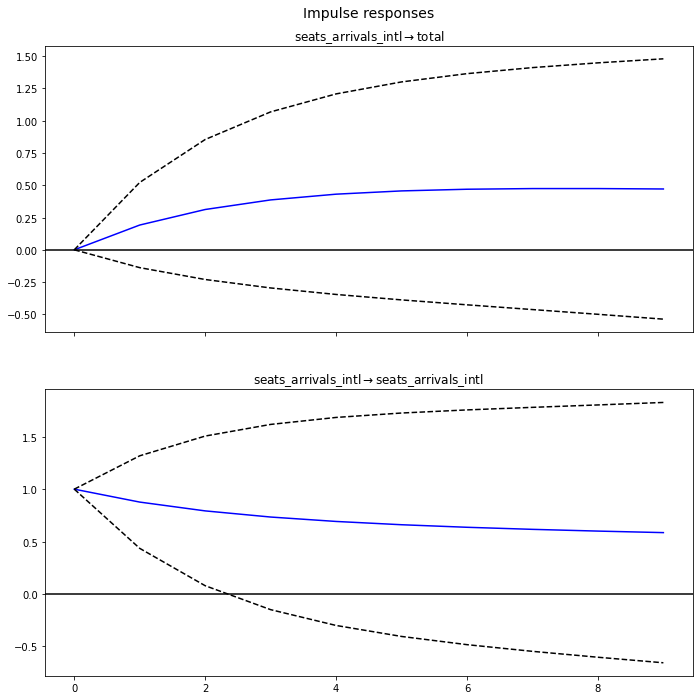

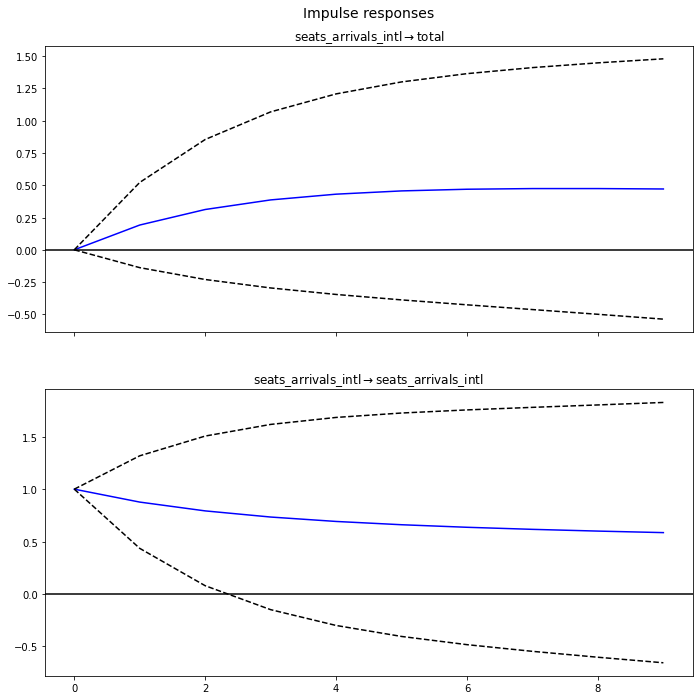

In [27]:
irf = model_fit.irf(9)
irf.plot(impulse='seats_arrivals_intl', orth=False)

In [28]:
# inverse transformation
pred = model_fit.fittedvalues
pred.columns = ["total_pred", "seats_arrivals_intl_pred"]
fj_pred = pd.concat([fj_merged[["dates", "total", "seats_arrivals_intl", "covid"]], pred], axis=1)
fj_pred.head(5)

,dates,total,seats_arrivals_intl,covid,total_pred,seats_arrivals_intl_pred
0,2019-01-01,63807,123265.0,0,NaN,NaN
1,2019-02-01,48748,86745.0,0,68499.385201,113792.927778
2,2019-03-01,59306,90965.0,0,50188.187848,79890.249177
3,2019-04-01,76813,105318.0,0,58923.668974,84911.386498
4,2019-05-01,73169,98428.0,0,74819.785898,99686.064687


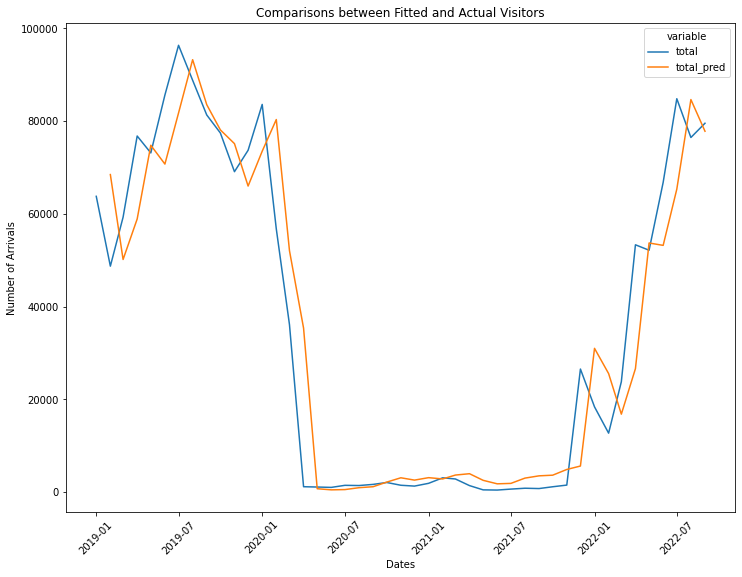

In [29]:
plt.figure(figsize=(12, 9))
sns.lineplot(
    data=fj_pred[["dates", "total", "total_pred"]].melt(id_vars=["dates"]),
    x="dates", y="value", hue="variable")

plt.xlabel("Dates")
plt.ylabel("Number of Arrivals") 
plt.title("Comparisons between Fitted and Actual Visitors")
plt.xticks(rotation=45)
plt.show()